In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem
from sklearn.decomposition import PCA



In [21]:
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# === Data Cleaning Helpers ===
def clean_smiles(s):
    if isinstance(s, str) and s.startswith('*'):
        return s[1:]
    return s

def identify_missing_values(df):
    print("\n--- Missing Values Summary ---")
    print(df.isna().sum())
    return df.isna().sum()

def detect_outliers_iqr(df, col):
    if col not in df.columns:
        print(f"Column {col} not found.")
        return []
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return df[(df[col] < lower) | (df[col] > upper)].index

def clean_data(df):
    print("\n--- Cleaning Data ---")
    df['SMILES'] = df['SMILES'].apply(clean_smiles)
    identify_missing_values(df)

    cols_to_check = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
    for col in cols_to_check:
        outliers = detect_outliers_iqr(df, col)
        print(f"{col}: Found {len(outliers)} potential outliers.")

    df = df.dropna(subset=['Tg'])
    return df



In [22]:
# === Data Loading ===
def load_data():
    data_path = os.path.join('..', 'data', 'train_cleaned.csv')
    df = pd.read_csv(data_path)
    df = clean_data(df)
    print("\n=== Dataset Info ===")
    print(df.info())
    print(df.describe())
    return df



In [23]:
# === Numeric EDA ===
def plot_numeric_features(df):
    num_cols = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
    for col in num_cols:
        if col not in df.columns:
            continue
        col_data = df[[col]].dropna()
        if col_data.empty:
            continue
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        sns.histplot(col_data[col], kde=True, color='skyblue')
        plt.title(f"Histogram of {col}")
        plt.subplot(1, 2, 2)
        sns.boxplot(x=col_data[col], color='lightgreen')
        plt.title(f"Boxplot of {col}")
        plt.tight_layout()
        plt.show()



In [24]:
def plot_correlation_matrix(df):
    num_cols = ['Tg', 'FFV', 'Tc', 'Density', 'Rg']
    corr_df = df[num_cols].dropna()
    if corr_df.empty:
        return
    corr = corr_df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix of Physical Features')
    plt.tight_layout()
    plt.show()



In [25]:
def scatter_plots_vs_tg(df):
    features = ['FFV', 'Tc', 'Density', 'Rg']
    for feat in features:
        if feat not in df.columns or 'Tg' not in df.columns:
            continue
        clean_df = df.dropna(subset=['Tg', feat])
        if clean_df.empty:
            continue
        plt.figure()
        sns.scatterplot(x=clean_df[feat], y=clean_df['Tg'])
        plt.title(f'{feat} vs Tg')
        plt.xlabel(feat)
        plt.ylabel('Tg')
        plt.tight_layout()
        plt.show()



In [26]:
# === Descriptor Features ===
def load_features():
    feat_path = os.path.join('..', 'data', 'train_features.csv')
    if not os.path.exists(feat_path):
        raise FileNotFoundError(f"Feature file not found at {feat_path}.")
    feat_df = pd.read_csv(feat_path)
    print("\n=== Features Loaded ===")
    print(feat_df.info())
    print(feat_df.describe())
    return feat_df



In [27]:
def plot_descriptor_correlation(feat_df):
    descriptor_cols = [
        'MolWt', 'MolLogP', 'TPSA', 'NumHDonors', 'NumHAcceptors',
        'NumRotatableBonds', 'RingCount', 'HeavyAtomCount', 'NHOHCount', 'NOCount']
    valid_cols = [col for col in descriptor_cols if col in feat_df.columns]
    if not valid_cols:
        return
    corr = feat_df[valid_cols].dropna().corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True, mask=mask)
    plt.title("Correlation Matrix of Descriptors")
    plt.tight_layout()
    plt.show()



In [28]:
def plot_descriptor_vs_target(feat_df):
    descriptor_cols = [
        'MolWt', 'MolLogP', 'TPSA', 'NumHDonors', 'NumHAcceptors',
        'NumRotatableBonds', 'RingCount', 'HeavyAtomCount', 'NHOHCount', 'NOCount']
    for desc in descriptor_cols:
        if desc not in feat_df.columns or 'Tg' not in feat_df.columns:
            continue
        clean_df = feat_df[[desc, 'Tg']].dropna()
        if clean_df.empty:
            continue
        plt.figure()
        sns.scatterplot(x=clean_df[desc], y=clean_df['Tg'], alpha=0.5)
        plt.title(f"{desc} vs Tg")
        plt.xlabel(desc)
        plt.ylabel("Tg")
        plt.tight_layout()
        plt.show()



In [29]:
# === PCA on Fingerprints ===
def pca_on_fingerprints(feat_df):
    fp_cols = [f'FP_{i}' for i in range(256) if f'FP_{i}' in feat_df.columns]
    if not fp_cols:
        return
    fps = feat_df[fp_cols].values
    pca = PCA(n_components=2)
    fps_2d = pca.fit_transform(fps)
    plt.figure()
    scatter = plt.scatter(fps_2d[:, 0], fps_2d[:, 1], c=feat_df['Tg'], cmap='viridis', s=15)
    plt.colorbar(scatter, label='Tg')
    plt.title("PCA of Fingerprints Colored by Tg")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()



In [30]:
# === RDKit Graph Features ===
def analyze_graph_features(df):
    from rdkit import RDLogger
    RDLogger.DisableLog('rdApp.*')
    mols = [Chem.MolFromSmiles(smi) for smi in df['SMILES']]
    df['NumAtoms'] = [mol.GetNumAtoms() if mol else np.nan for mol in mols]
    df['NumBonds'] = [mol.GetNumBonds() if mol else np.nan for mol in mols]
    plt.figure()
    sns.histplot(df['NumAtoms'].dropna(), bins=30, color='orange')
    plt.title("Number of Atoms per Polymer")
    plt.tight_layout()
    plt.show()
    plt.figure()
    sns.histplot(df['NumBonds'].dropna(), bins=30, color='green')
    plt.title("Number of Bonds per Polymer")
    plt.tight_layout()
    plt.show()
    degrees = []
    for mol in mols:
        if mol:
            degrees.extend([atom.GetDegree() for atom in mol.GetAtoms()])
    if degrees:
        plt.figure()
        sns.histplot(degrees, bins=20, color='purple')
        plt.title("Atom Degree Distribution")
        plt.tight_layout()
        plt.show()



Starting Full EDA for Polymer Dataset...


--- Cleaning Data ---

--- Missing Values Summary ---
id            0
SMILES        0
Tg         7462
FFV         943
Tc         7236
Density    7360
Rg         7359
dtype: int64
Tg: Found 13 potential outliers.
FFV: Found 269 potential outliers.
Tc: Found 0 potential outliers.
Density: Found 21 potential outliers.
Rg: Found 2 potential outliers.

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
Index: 511 entries, 40 to 7971
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       511 non-null    int64  
 1   SMILES   511 non-null    object 
 2   Tg       511 non-null    float64
 3   FFV      1 non-null      float64
 4   Tc       32 non-null     float64
 5   Density  24 non-null     float64
 6   Rg       24 non-null     float64
dtypes: float64(5), int64(1), object(1)
memory usage: 31.9+ KB
None
                 id          Tg       FFV         Tc    Density         Rg


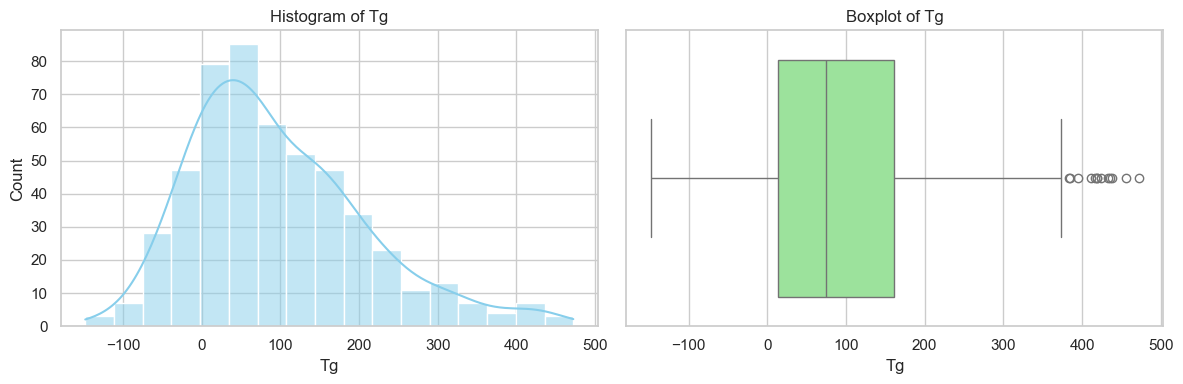

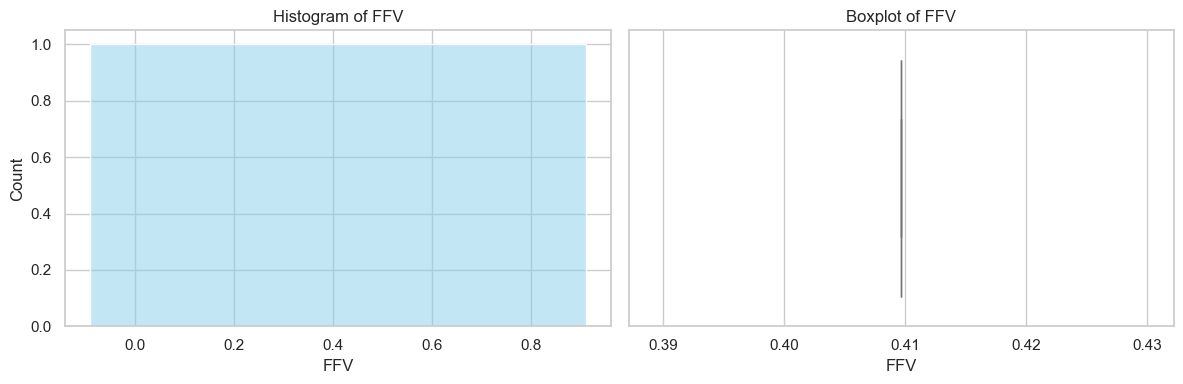

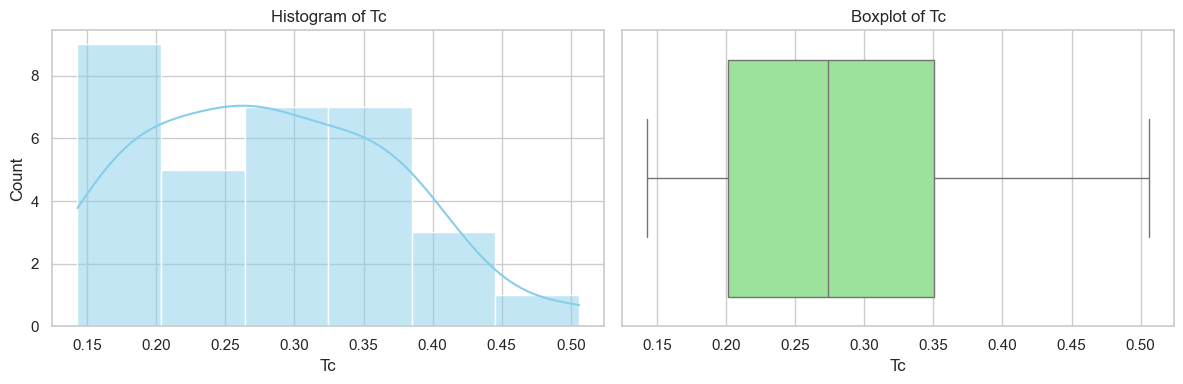

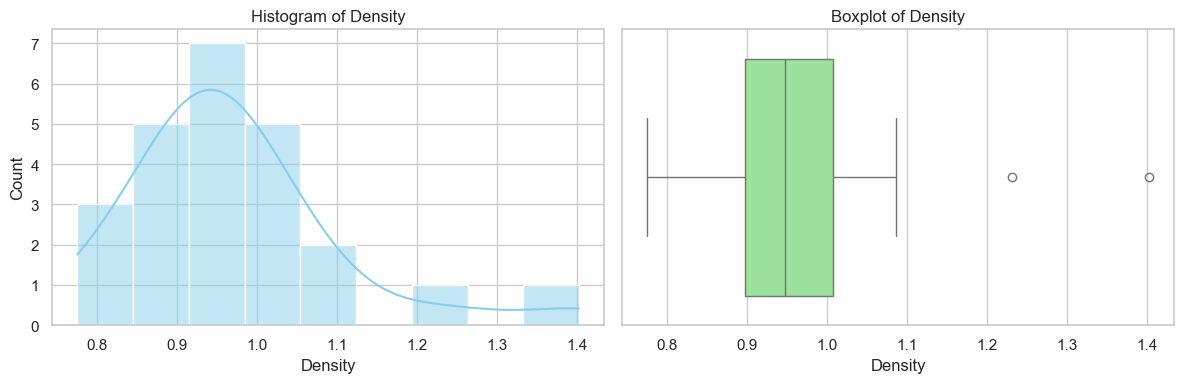

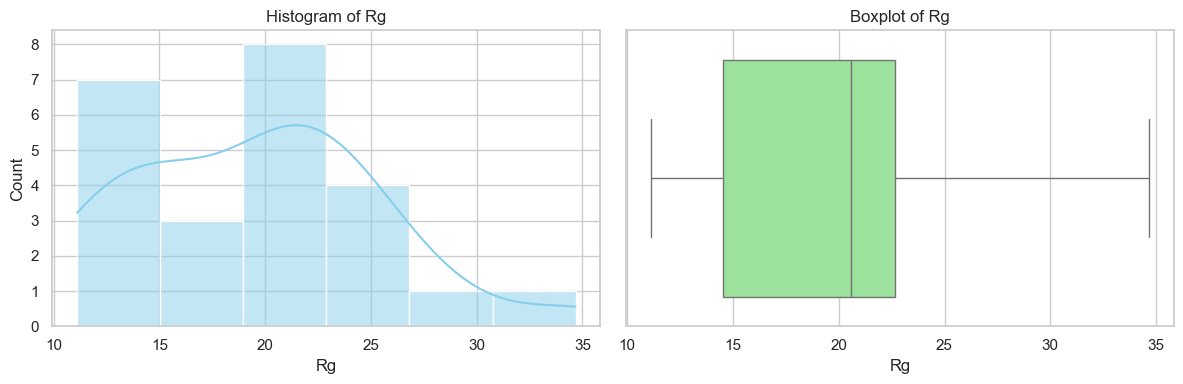

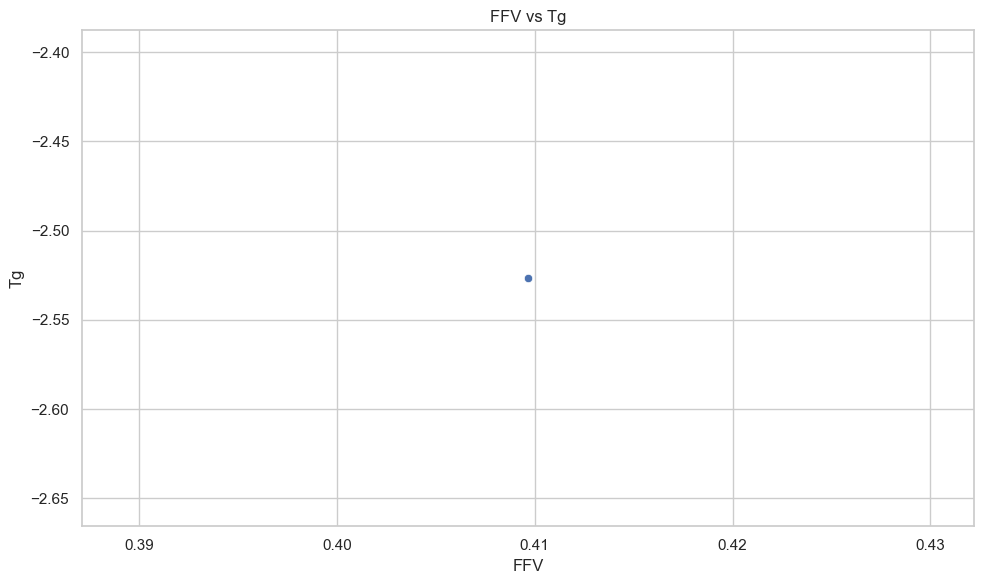

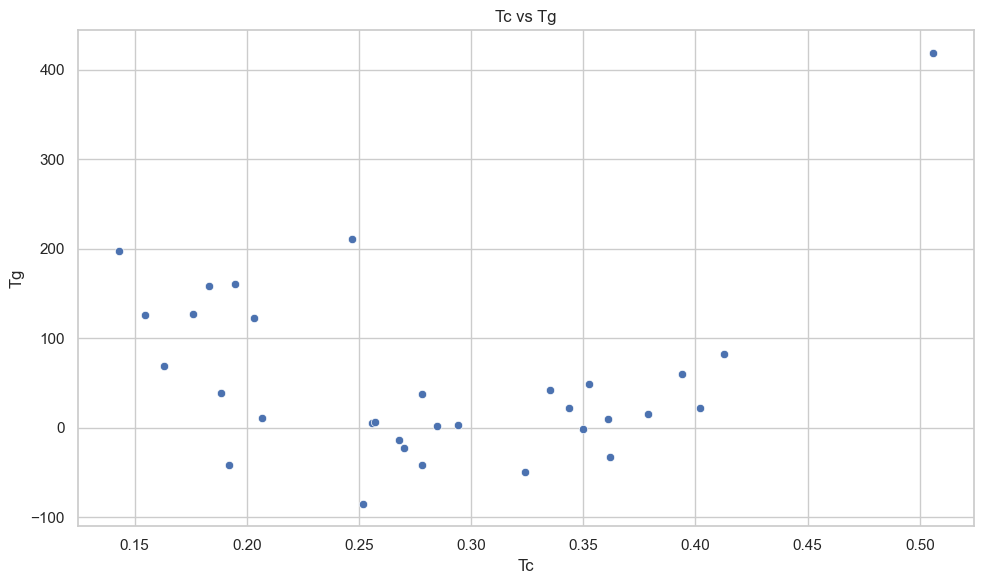

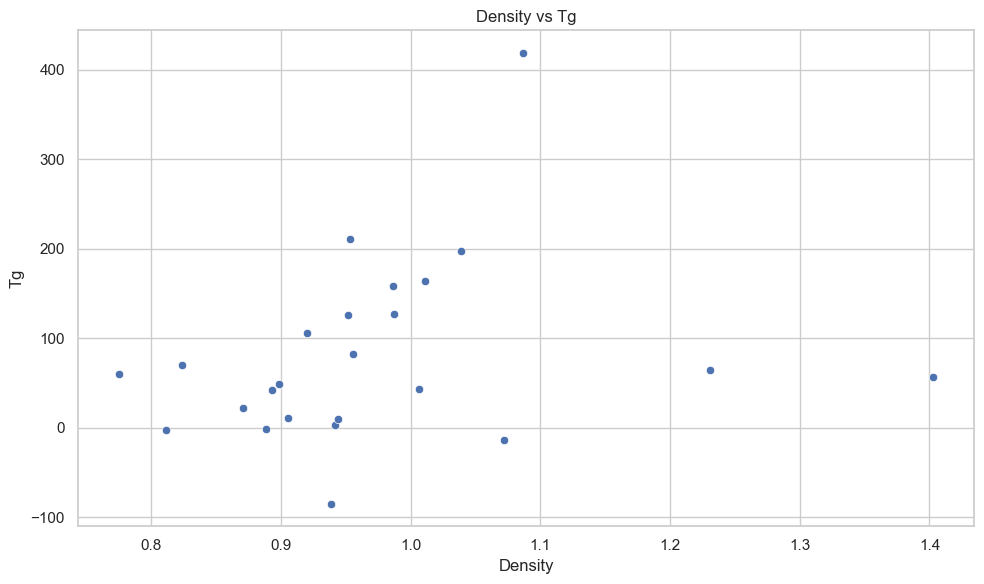

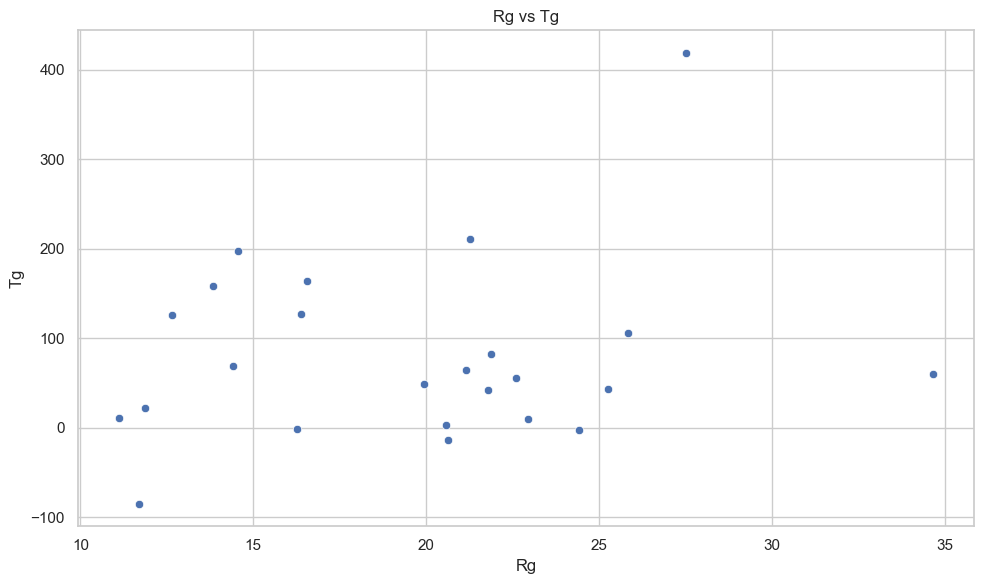


=== Features Loaded ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7973 entries, 0 to 7972
Columns: 273 entries, id to FP_255
dtypes: float64(8), int64(264), object(1)
memory usage: 16.6+ MB
None
                 id          Tg          FFV          Tc     Density  \
count  7.973000e+03  511.000000  7030.000000  737.000000  613.000000   
mean   1.080050e+09   96.452314     0.367212    0.256334    0.985484   
std    6.218241e+08  111.228279     0.029609    0.089538    0.146189   
min    8.781700e+04 -148.029738     0.226992    0.046500    0.748691   
25%    5.376641e+08   13.674509     0.349549    0.186000    0.890243   
50%    1.079079e+09   74.040183     0.364264    0.236000    0.948193   
75%    1.621708e+09  161.147595     0.380790    0.330500    1.062096   
max    2.147438e+09  472.250000     0.777097    0.524000    1.840999   

               Rg        MolWt      MolLogP         TPSA   NumHDonors  ...  \
count  614.000000  7973.000000  7973.000000  7973.000000  7973.000000

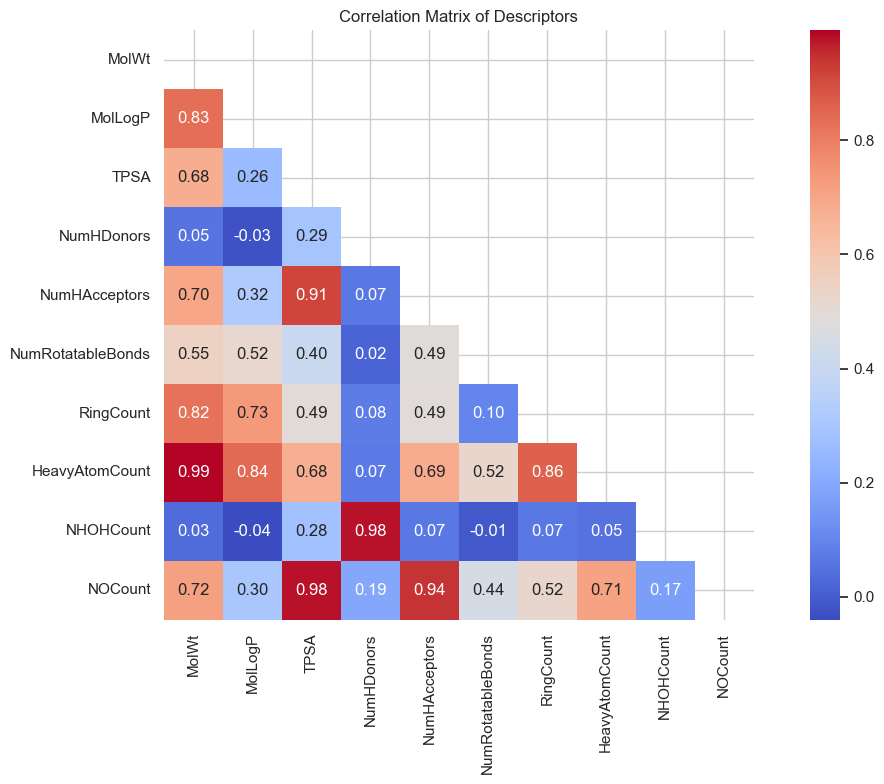

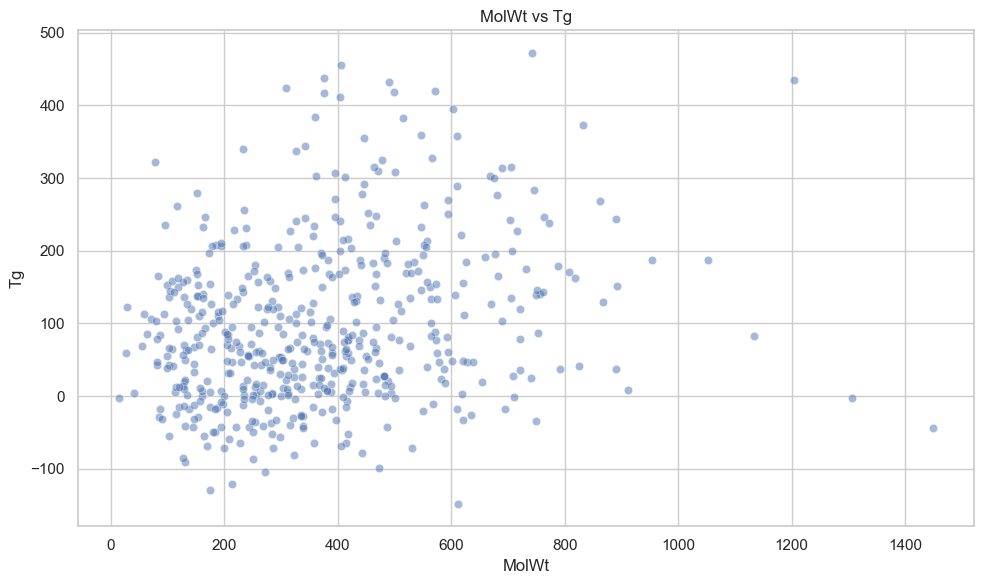

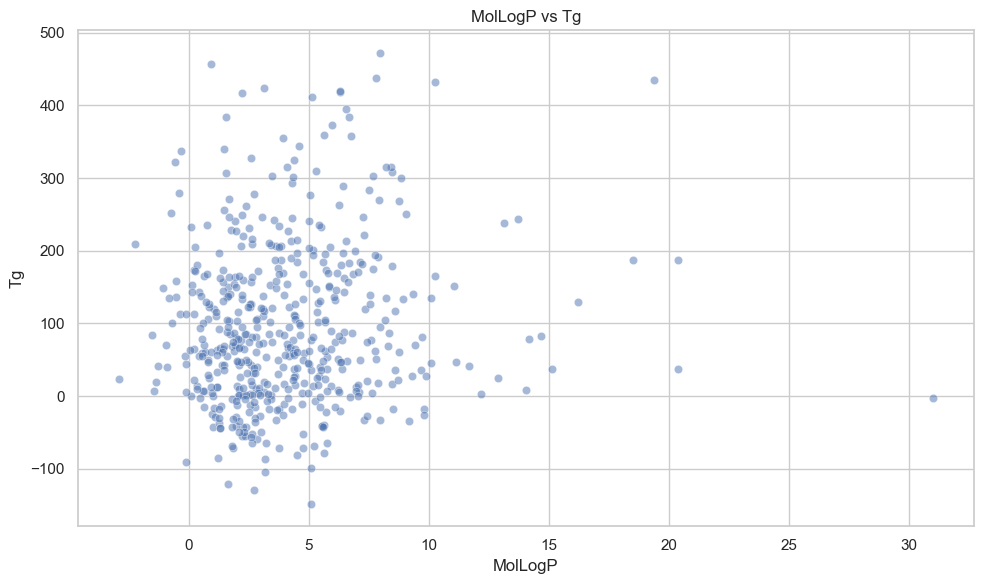

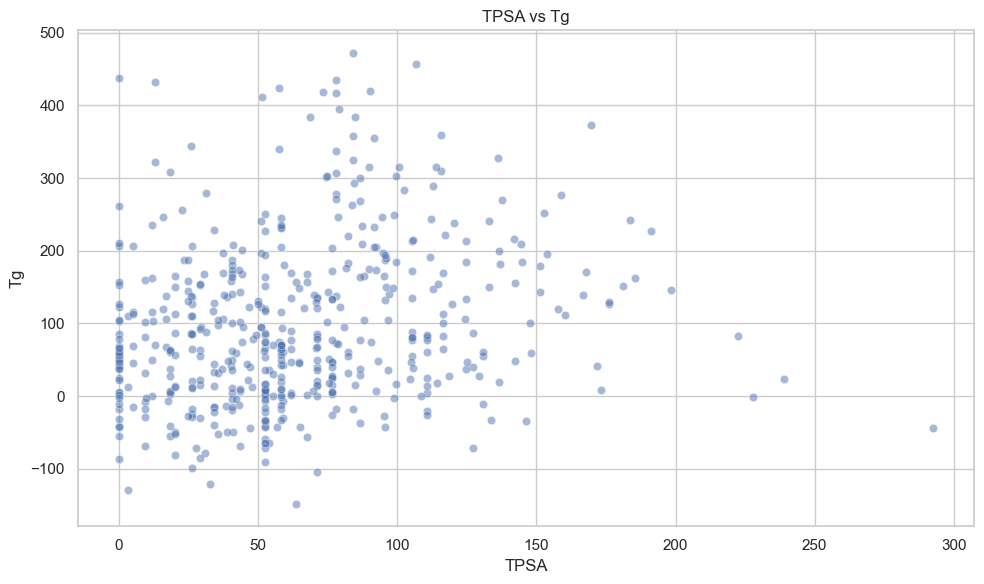

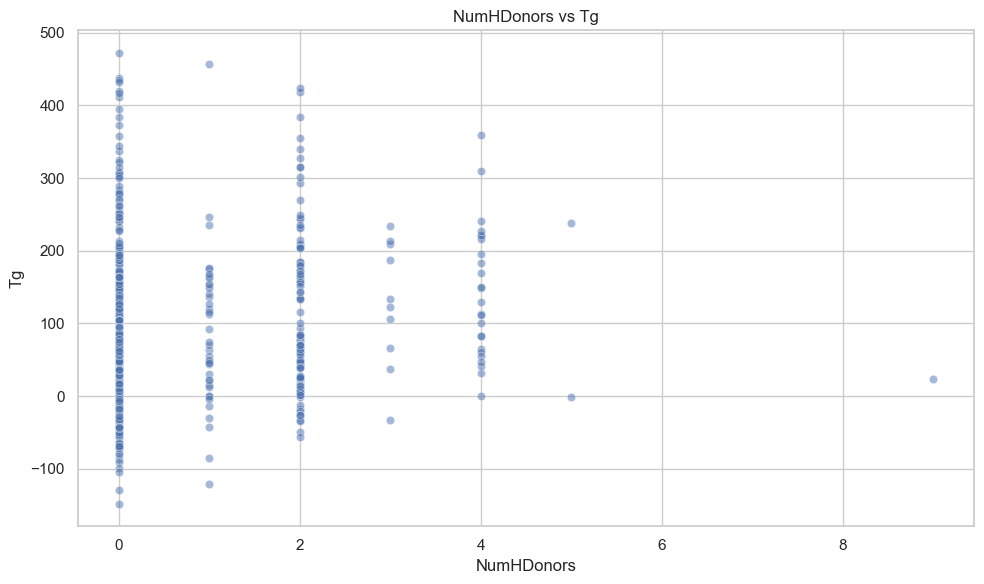

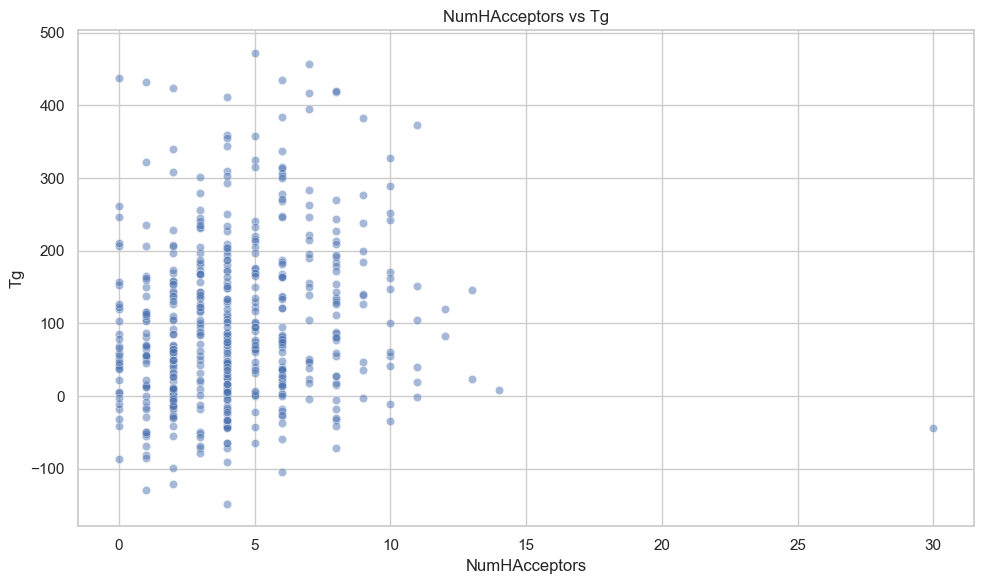

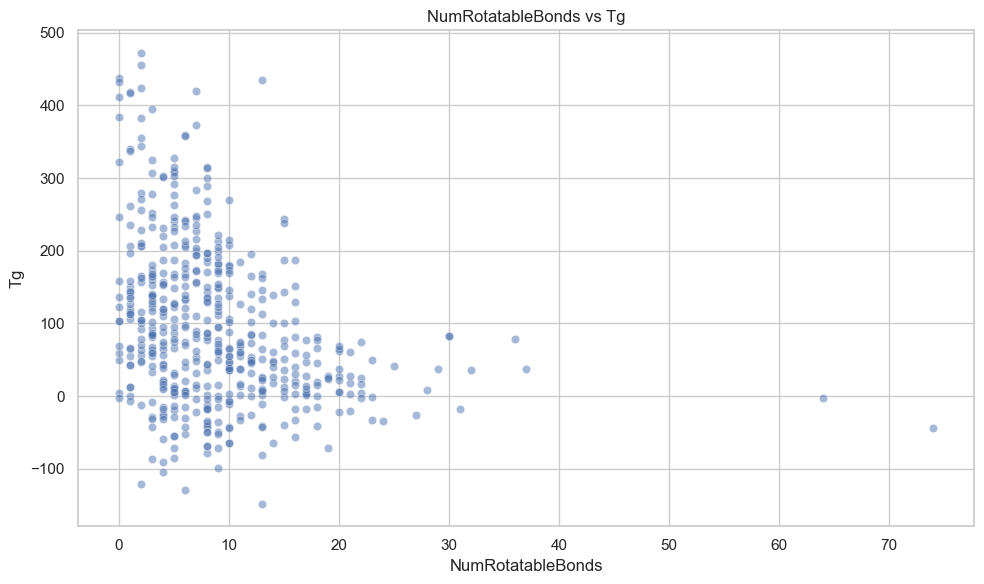

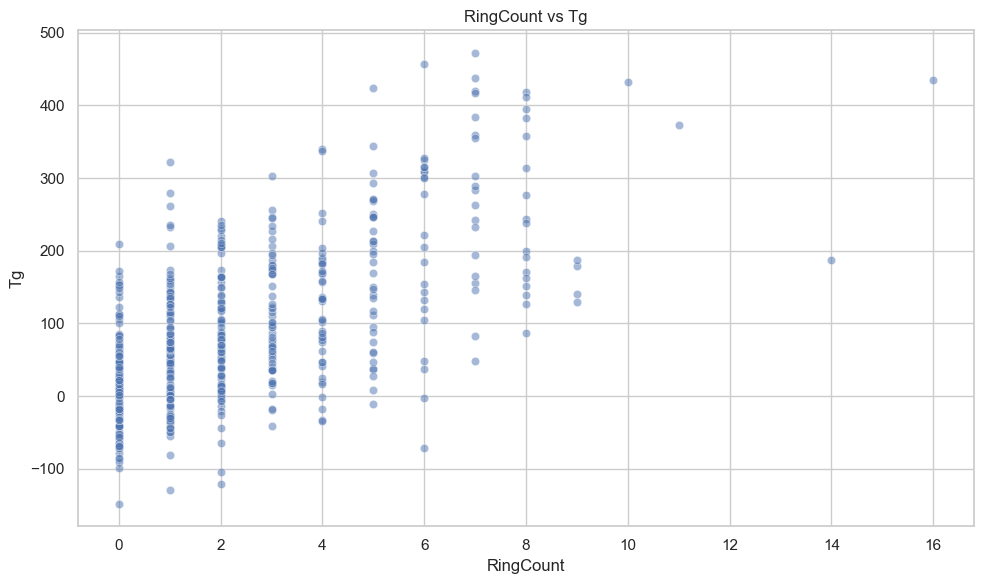

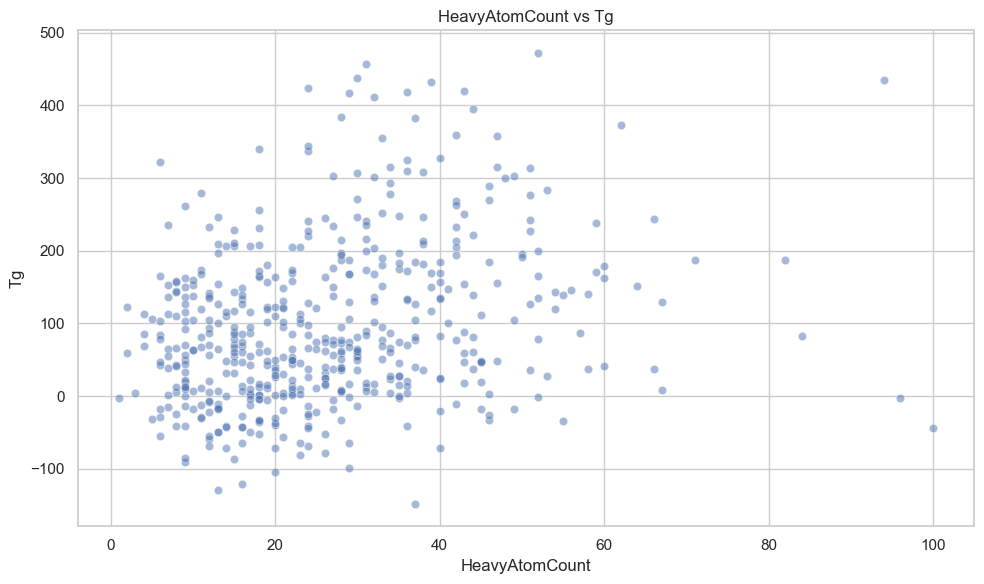

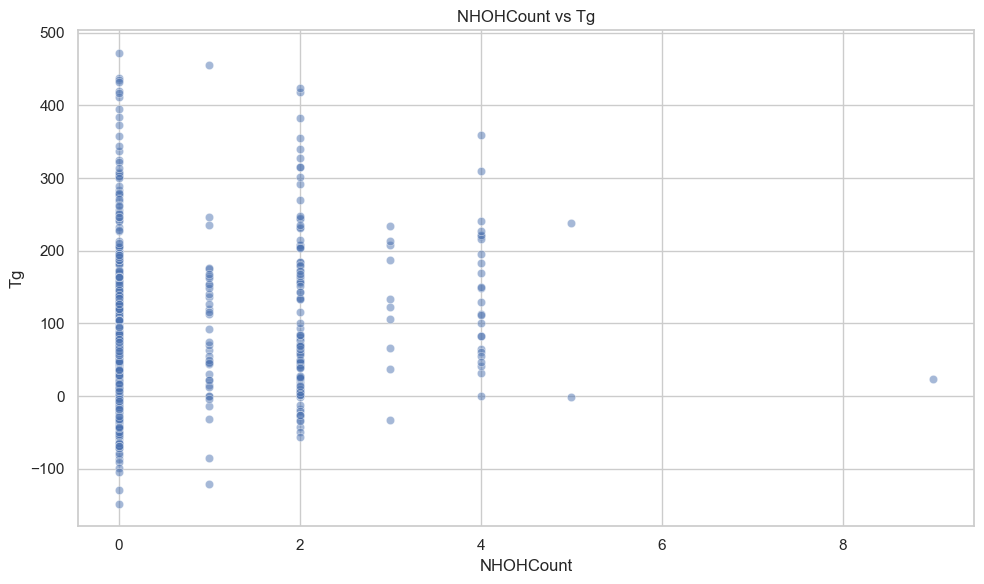

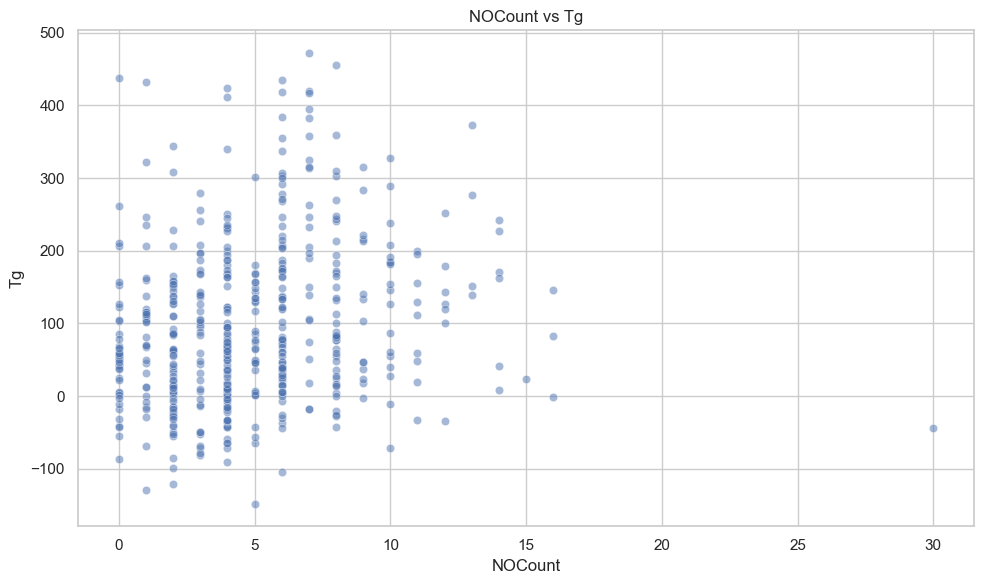

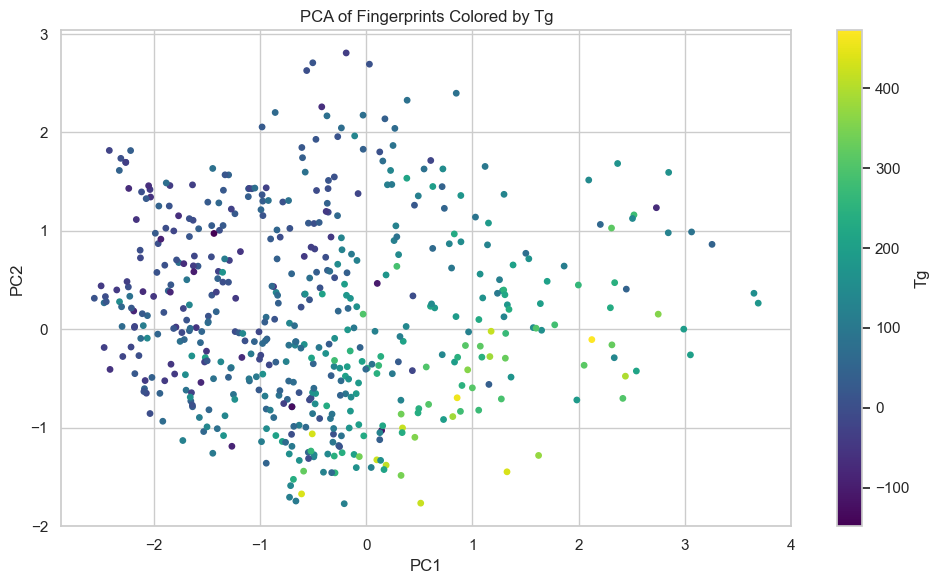

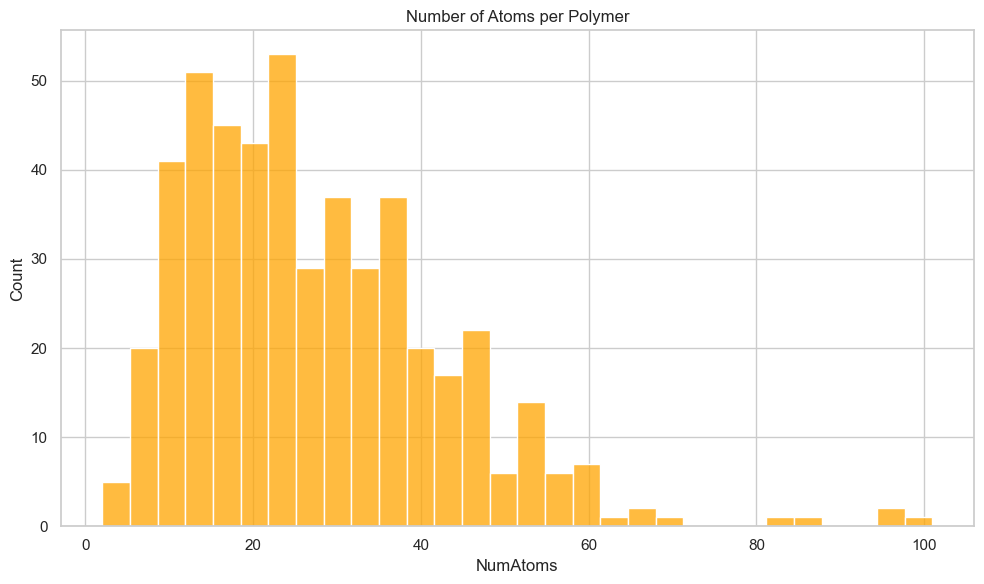

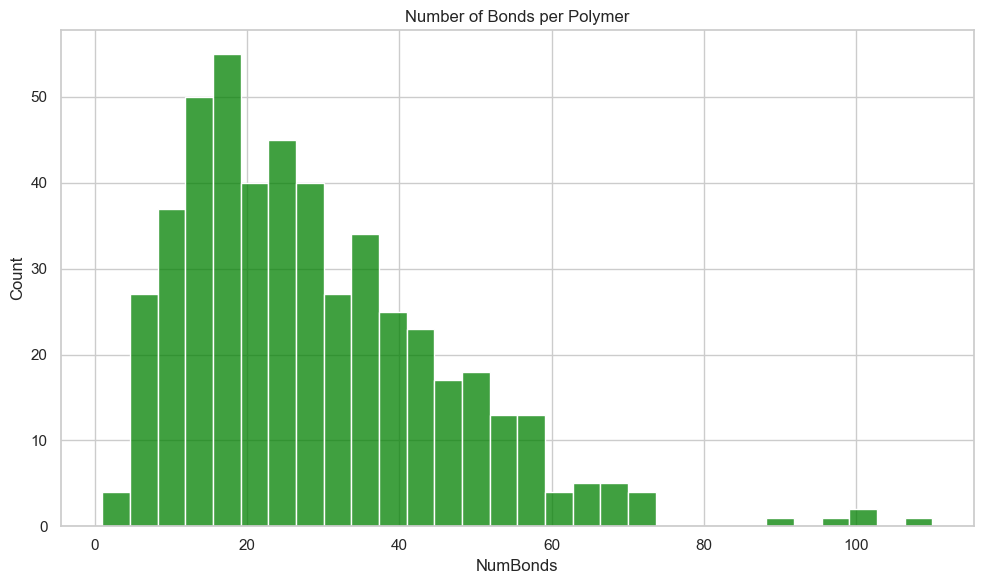

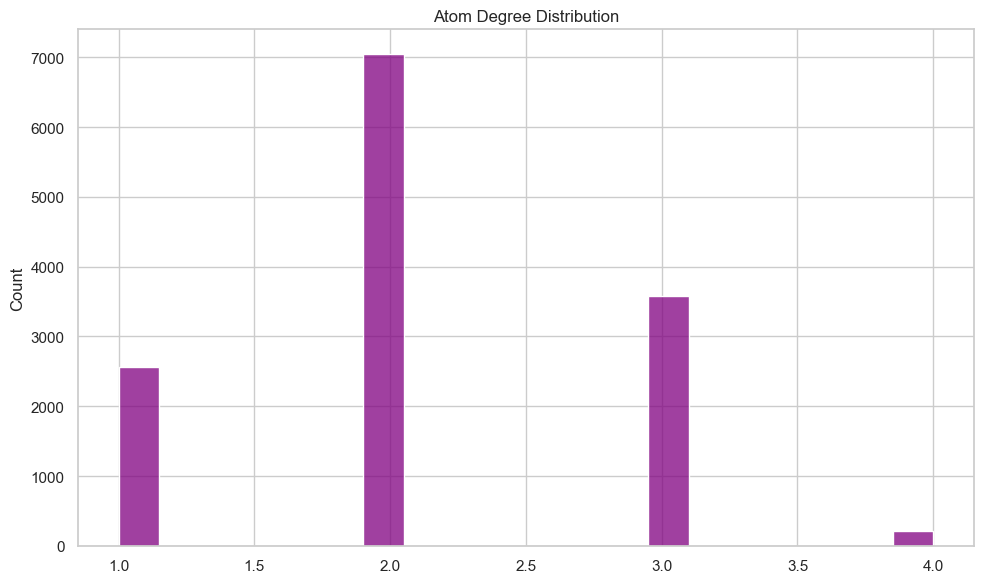

In [32]:
# === Master Execution ===
def main():
    print("Starting Full EDA for Polymer Dataset...\n")
    df = load_data()
    plot_numeric_features(df)
    plot_correlation_matrix(df)
    scatter_plots_vs_tg(df)
    feat_df = load_features()
    plot_descriptor_correlation(feat_df)
    plot_descriptor_vs_target(feat_df)
    pca_on_fingerprints(feat_df)
    analyze_graph_features(df)

if __name__ == "__main__":
    main()